In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from enum import Enum, auto

In [2]:
TORCH_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TORCH_DTYPE = torch.float32
TORCH_CDTYPE = torch.complex64

In [3]:
class SquareGrid:
    def __init__(self, xmin, xmax, N):
        self.N = N
        self.dx = (xmax - xmin) / N
        self.x = xmin + torch.arange(self.N, device=TORCH_DEVICE, dtype=TORCH_DTYPE) * self.dx
        self.kx = torch.fft.fftfreq(self.N, d=self.dx, device=TORCH_DEVICE).to(TORCH_DTYPE) * 2 * torch.pi

    @property
    def X(self): 
        return self.x[:, None]
    
    @property
    def Y(self): 
        return self.x[None, :]
    
    @property
    def Rsq(self): 
        return self.X.square() + self.Y.square()
    
    @property
    def KX(self): 
        return self.kx[:, None]
    
    @property
    def KY(self): 
        return self.kx[None, :]
    
    @property
    def Ksq(self): 
        return self.KX.square() + self.KY.square()
    
class BeamShape(Enum):
    GAUSSIAN = auto()

class PropMedium(Enum):
    VACUUM = auto()

class Beam:
    def __init__(self, grid: SquareGrid, w_param, shape: BeamShape = BeamShape.GAUSSIAN, wavelength = 1550e-9):
        self.shape = shape
        self.wavelength = wavelength
        self.k0 = 2*torch.pi/self.wavelength
        self.w = w_param
        match self.shape:
            case BeamShape.GAUSSIAN:
                self.E0 = torch.exp(-grid.Rsq / self.w**2)
    
class SSFStepper:
    def __init__(self, beam: Beam, grid: SquareGrid, dz=1, medium: PropMedium = PropMedium.VACUUM):
        self.medium = medium
        self.beam = beam
        self.grid = grid
        self.dz = dz
        match self.medium:
            case PropMedium.VACUUM:
                phi = -dz * self.grid.Ksq / (2 * self.beam.k0)
                self.D = torch.exp(1j * phi).to(TORCH_CDTYPE)
    def __call__(self, E):
        match self.medium:
            case PropMedium.VACUUM:
                return torch.fft.ifft2(self.D * torch.fft.fft2(E))


In [4]:
xmin = -0.5
xmax = 0.5
N = 2048
w = 0.01
wavelength = 1550e-9
k0 = 2 * np.pi / wavelength
z_R = (w**2) * k0/2
dz = 1
z_steps = 5000
w_z_gauss = w * np.sqrt(1 + ((z_steps*dz)/z_R)**2)
grid = SquareGrid(xmin, xmax, N)
beam = Beam(grid, w, wavelength=wavelength)
SSF = SSFStepper(beam, grid, dz = dz)
E = beam.E0
for _ in range(z_steps):
    E = SSF(E)

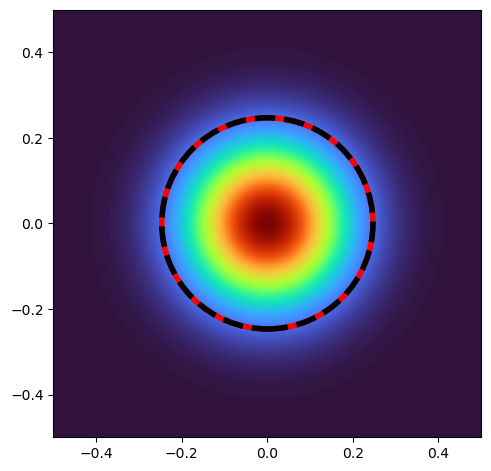

In [5]:
I0 = beam.E0.abs().square().cpu().numpy()
I1 = E.abs().square().cpu().numpy()
Rsq = grid.Rsq.cpu().numpy()


X, Y = grid.X.cpu().numpy(), grid.Y.cpu().numpy()
xbar = np.sum(X * I1)/np.sum(I1)
ybar = np.sum(Y * I1)/np.sum(I1)
sigma_x_sq = np.sum(I1 * (X-xbar)**2)/np.sum(I1) 
sigma_y_sq = np.sum(I1 * (Y-ybar)**2)/np.sum(I1) 
weff = np.sqrt(2) * np.sqrt(sigma_x_sq + sigma_y_sq)
plt.figure(figsize=(5,5), dpi=100)
theor_circle1 = plt.Circle((0, 0), w_z_gauss, color="r", ls="-", lw=4, fill=False)
eff_circle1 = plt.Circle((0, 0), weff, ls = "--", lw = 4, fill=False)
ax = plt.gca()
ax.add_patch(theor_circle1)
ax.add_patch(eff_circle1)
plt.imshow(I1, cmap="turbo", extent=[xmin,xmax,xmin,xmax])

#zoom = (-0.2, 0.2)
#plt.xlim(zoom)
#plt.ylim(zoom)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()